# BDEA Projekt Nr. 1 - Sleep Analysis

### Import libraries and connect with database

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mysql.connector
import warnings
warnings.filterwarnings('ignore')

In [2]:
connection = mysql.connector.connect(user='root', password='secret',
                              host='mariadb',
                              database='mydb_bdea')
cur = connection.cursor()

### Load data from *.csv*-File into table *sleep_data*

In [3]:
cur.execute("LOAD DATA INFILE '/var/lib/mydb_bdea/sleep_data.csv' INTO TABLE sleep_data FIELDS TERMINATED BY ';' LINES TERMINATED BY '\r\n';")

### Data overview: Duration time of sleep stages of each record 

Load data

In [4]:
query = "SELECT startDay, deepSleepSeconds, lightSleepSeconds, REMSleepSeconds, awakeSeconds, unmeasuredSeconds FROM sleep_data;" # extract necessary columns
df_sec = pd.read_sql_query(query, connection)

Change datatype

In [5]:
cols = ["deepSleepSeconds", "lightSleepSeconds", "REMSleepSeconds", "awakeSeconds", "unmeasuredSeconds"]
df_sec[cols] = df_sec[cols].apply(pd.to_numeric) # change datatype into numeric
for col in cols:
    df_sec[col] = df_sec[col]/60/60 # change from seconds into hours
df_sec['durationSeconds'] = df_sec[cols].sum(axis=1) # calculate duration
for col in cols: # add relative value for each column
    df_sec[col+'Relativ'] = df_sec[col]/df_sec['durationSeconds']

Plot image

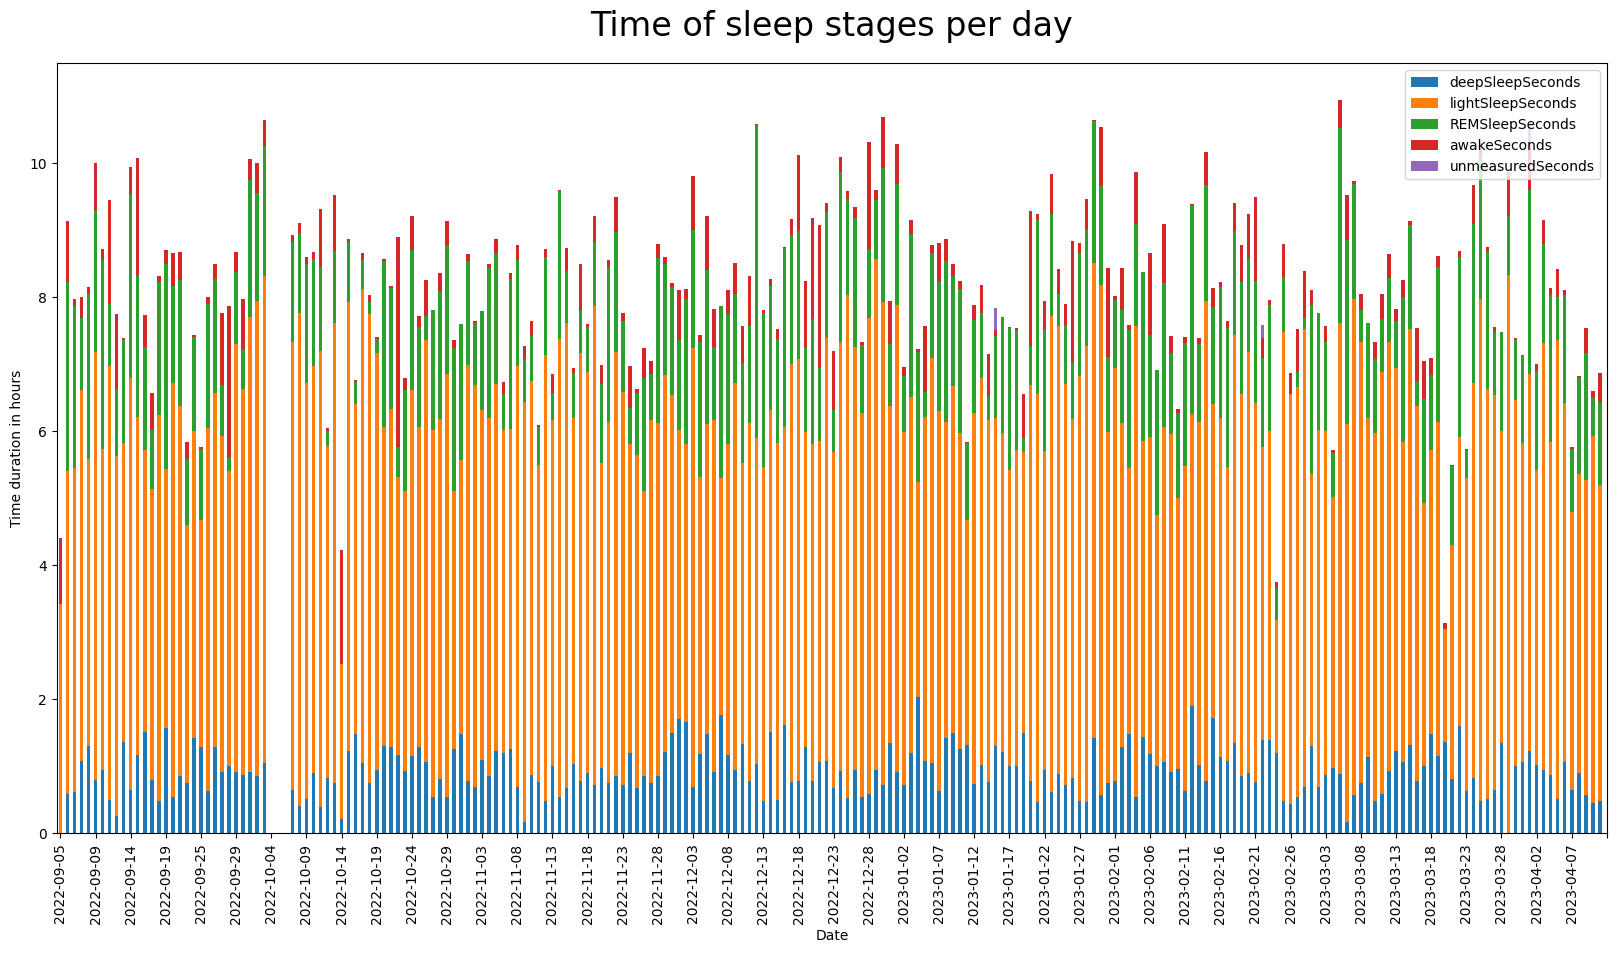

In [6]:
ax = df_sec.plot.bar(x="startDay", y=["deepSleepSeconds", "lightSleepSeconds", "REMSleepSeconds", "awakeSeconds", "unmeasuredSeconds"], stacked=True, figsize=(20, 10));
ax.set_ylabel("Time duration in hours")
ax.set_xlabel("Date")
ax.set_title('Time of sleep stages per day', pad=20, fontdict={'fontsize':24})
plt.xticks(np.arange(0, len(df_sec.startDay)+1, 5)); # show only every 5th date as x-label

=> Der leichte Schlaf nimmt am meisten Schlafenszeit ein.

Betrachten wir als nächstes die Schlafdauer pro Wochentag:

## Calculate average sleep duration per weekday

Load Data

In [7]:
query = "SELECT startDay, startTime, endDay, endTime, deepSleepSeconds, REMSleepSeconds, unmeasuredSeconds FROM sleep_data;"
df = pd.read_sql_query(query, connection)

Convert data types

In [8]:
df["start"] = df['startDay'].astype(str) +"T"+ df["startTime"] # concatenate Day and Time
df["end"] = df['endDay'].astype(str) +"T"+ df["endTime"] # concatenate Day and Time

In [9]:
df["startDay"] = pd.to_datetime(df["startDay"], errors='coerce') # change datatype into datetime
df["endDay"] = pd.to_datetime(df["endDay"], errors='coerce') # change datatype into datetime

In [10]:
cols = ["deepSleepSeconds", "REMSleepSeconds", "unmeasuredSeconds"]
df[cols] = df[cols].apply(pd.to_numeric) # change datatype into numeric

In [11]:
df["start"] = pd.to_datetime(df["start"], format='ISO8601', errors='coerce') # change datatype into datetime
df["end"] = pd.to_datetime(df["end"], format='ISO8601', errors='coerce') # change datatype into datetime

In [12]:
df['startTime'] = pd.to_datetime(df['startTime'],format= '%H:%M:%S') # change datatype into datetime
df['endTime'] = pd.to_datetime(df['endTime'],format= '%H:%M:%S') # change datatype into datetime

Calculate sleepDuration

In [13]:
df['sleepDuration'] = df['end'] - df['start'] # calculate sleepDuration
df['sleepDuration'] = df['sleepDuration'] / np.timedelta64(1, 'h') # convert timedelta datatype in hours
df['weekday'] = df['endDay'].dt.dayofweek # extract weekday
# change numeric weekday in text 
df['weekday'] = df['weekday'].map({0.0: 'Monday', 1.0: 'Tuesday', 2.0: 'Wednesday', 3.0: 'Thursday', 4.0: 'Friday', 5.0: 'Saturday', 6.0: 'Sunday'})

Create a new Dataframe with sleepDuration per weekday

In [14]:
df_new = pd.DataFrame({'sleepDuration': df['sleepDuration'], 'weekday': df['weekday']}) # create new df
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # create cats for ordering weekdays
df_new['weekday'] = pd.Categorical(df_new['weekday'], categories=cats, ordered=True) # order weekdays

df_new = df_new.groupby('weekday').mean() # calculate sleepDuration mean per weekday

Plot bar chart

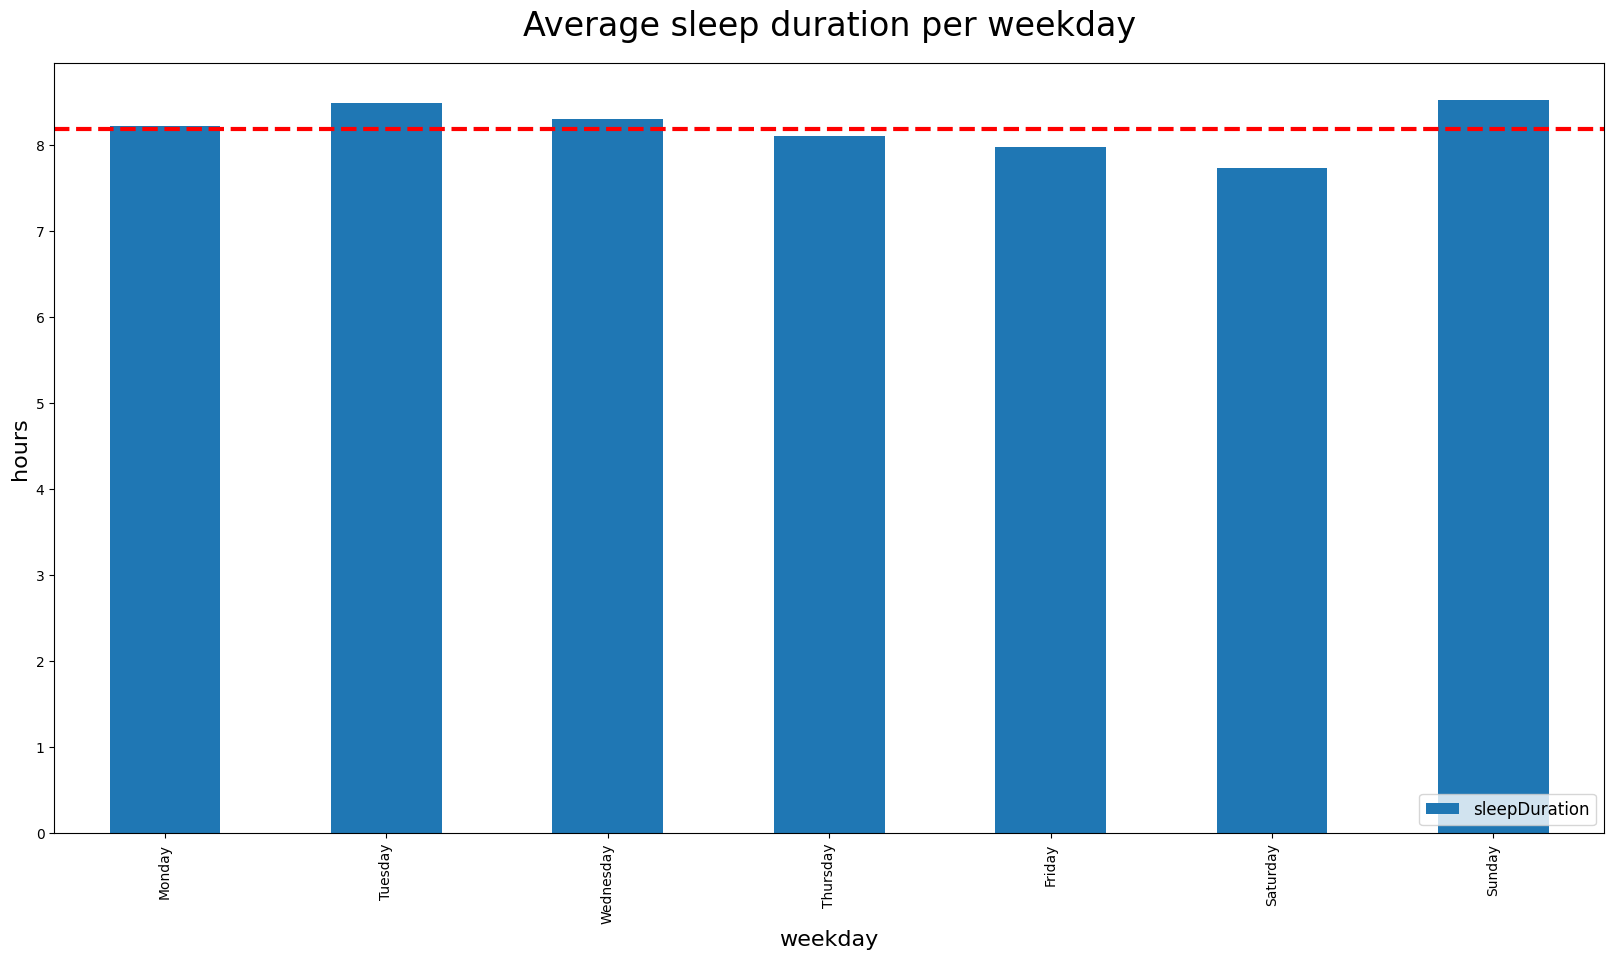

In [15]:
ax1 = df_new.plot(kind='bar', figsize=(20, 10), ylabel = 'hours')
ax1.legend(loc=4, fontsize=12)
ax1.set_ylabel('hours',fontdict={'fontsize':16})
ax1.set_xlabel('weekday',fontdict={'fontsize':16})
ax1.set_title('Average sleep duration per weekday', pad=20, fontdict={'fontsize':24})
plt.axhline(y=np.nanmean(df_new['sleepDuration']), color='red', linestyle='--', linewidth=3, label='Avg'); # add average line

=> Am Freitag und Samstag wird verhältnismäßig weniger geschlafen

### Boxplots of individual sleep scores divided into positive and negative sleepFeedback

Extract data

In [16]:
#extract data
query = '''SELECT overallScore, qualityScore, durationScore, recoveryScore, deepScore, REMScore, lightScore, awakeningsCountScore, awakeTimeScore, combinedAwakeScore, restfulnessScore, interruptionsScore FROM sleep_data WHERE sleepFeedback LIKE 'NEGATIVE%';'''
df_score_neg = pd.read_sql(query, connection)

query = '''SELECT overallScore, qualityScore, durationScore, recoveryScore, deepScore, REMScore, lightScore, awakeningsCountScore, awakeTimeScore, combinedAwakeScore, restfulnessScore, interruptionsScore FROM sleep_data WHERE sleepFeedback LIKE 'POSITIVE%';'''
df_score_pos = pd.read_sql(query, connection)

Convert datatype and delete 0 values

In [17]:
cols = ["overallScore", "qualityScore", "durationScore", "recoveryScore", "deepScore", "REMScore", "lightScore", "awakeningsCountScore", "awakeTimeScore", "combinedAwakeScore", "restfulnessScore", "interruptionsScore"]
df_score_neg[cols] = df_score_neg[cols].apply(pd.to_numeric) # change data type into numeric
df_score_pos[cols] = df_score_pos[cols].apply(pd.to_numeric) # change data type into numeric

df_score_neg[cols] = df_score_neg[cols].mask(df_score_neg[cols] <= 0) # replace all values <= 0 with NaN
df_score_pos[cols] = df_score_pos[cols].mask(df_score_pos[cols] <= 0) # replace all values <= 0 with NaN

Plot boxplots

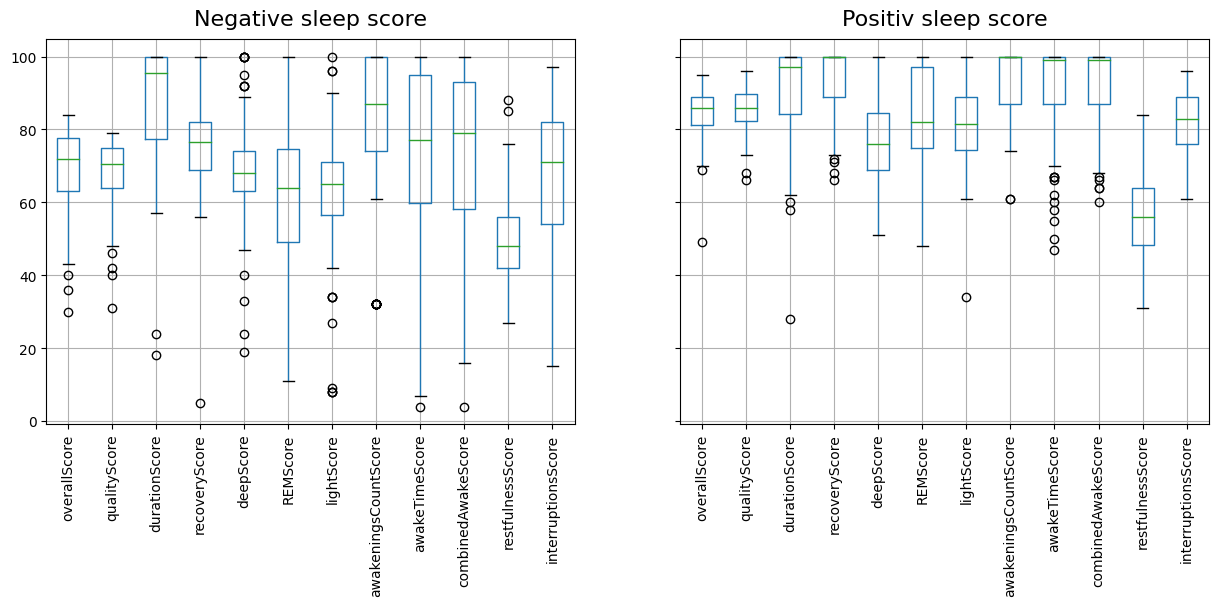

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
boxplot = df_score_neg.boxplot(ax=axes[0], column=cols, rot=90)
boxplot = df_score_pos.boxplot(ax=axes[1], column=cols, rot=90)
axes[0].set_title('Negative sleep score', pad=10, fontdict={'fontsize':16});
axes[1].set_title('Positiv sleep score', pad=10, fontdict={'fontsize':16});

* Der OverallScore liegt bei negativem sleepFeedback bei 67 % und bei positivem bei 85 %.
* Bezüglich der gesamten Schlafdauer, der Aufwachhäufigkeit und -dauer sind sowohl bei positivem, als auch bei negativem Score, im Verhältnis die besten Ergebnisse zu verzeichnen.
* Der recoveryScore unterschiedet sich zwischen beiden Diagrammen deutlich.
* Der Score für Tief-, REM- und leichten Schlaf ist bei beiden Diagrammen im Verhältnis geringer. Besonders gering fällt aber der restfulnessScore aus. Tief-, REM- und leichten Schlaf werden mit einem niedrigen Score bewertet, wenn die Schlafphasen zu kurz oder zu lange andauern. Der restfulnessScore fällt schlecht aus, wenn das Stresslevel in der Nacht zu hoch ist. 

### Consider the relative proportion per sleep stage and the desired value

In [19]:
cols = ["deepSleepSecondsRelativ", "lightSleepSecondsRelativ", "REMSleepSecondsRelativ", "awakeSecondsRelativ", "unmeasuredSecondsRelativ"]
df_new = pd.DataFrame({'mean': df_sec[cols].mean().round(2), 'minValue': [16,30,21,0,0.0], 'maxValue': [33,64,31,0.3,0] }) # add min and max desired relative values 
print(df_new)

                          mean  minValue  maxValue
deepSleepSecondsRelativ   0.12      16.0      33.0
lightSleepSecondsRelativ  0.66      30.0      64.0
REMSleepSecondsRelativ    0.18      21.0      31.0
awakeSecondsRelativ       0.05       0.0       0.3
unmeasuredSecondsRelativ  0.00       0.0       0.0


Der niedrige Score für Tief-, REM- und leichten Schlaf ist dadurch zu begründen, dass zu wenig Tief- und REM-Schlaf und zu viel leichter Schlaf auftritt.

### Sleep score, sleep stress level and heart rate for negative and positive score

In [20]:
# calculate metrix for negative score
query = "SELECT overallScore, RestingHeartRate, maxAvgHeartRate, AsleepAverageStressLevel, sleepFeedback, insight FROM sleep_data WHERE sleepFeedback LIKE 'NEGATIVE%';"
df_neg = pd.read_sql(query, connection)
cols = ["overallScore", "RestingHeartRate", "maxAvgHeartRate", "AsleepAverageStressLevel"]
df_neg[cols] = df_neg[cols].apply(pd.to_numeric) # change datatype into numeric
df_neg['AsleepAverageStressLevel'] = df_neg['AsleepAverageStressLevel'].mask(df_neg['AsleepAverageStressLevel'] <= 0) # clean data
df_neg["overallSleepScore"] = df_neg["overallScore"] # rename column
df_neg.drop(df_neg["overallScore"])
df_neg['RestingHeartRate_Roll'] = df_neg["RestingHeartRate"].rolling(10).mean() # add moving average for better visualization
df_neg['AsleepAverageStressLevel_Roll'] = df_neg["AsleepAverageStressLevel"].rolling(10).mean() # add moving average
df_neg['maxAvgHeartRate_Roll'] = df_neg["maxAvgHeartRate"].rolling(10).mean() # add moving average
df_neg['overallSleepScore_Roll'] = df_neg["overallScore"].rolling(10).mean() # add moving average

In [21]:
# calculate metrix for positiv score
query = "SELECT overallScore, RestingHeartRate, maxAvgHeartRate, AsleepAverageStressLevel, sleepFeedback, insight FROM sleep_data WHERE sleepFeedback LIKE 'POSITIVE%';"
df_pos = pd.read_sql(query, connection)
cols = ["overallScore", "RestingHeartRate", "maxAvgHeartRate", "AsleepAverageStressLevel"]
df_pos[cols] = df_pos[cols].apply(pd.to_numeric) # change datatype into numeric
df_pos['AsleepAverageStressLevel'] = df_pos['AsleepAverageStressLevel'].mask(df_pos['AsleepAverageStressLevel'] <= 0) # replace all values <= 0 with NaN
df_pos["overallSleepScore"] = df_pos["overallScore"] # rename column
df_pos.drop(df_pos["overallScore"])
df_pos['RestingHeartRate_Roll'] = df_pos["RestingHeartRate"].rolling(10).mean() # add moving average for better visualization
df_pos['AsleepAverageStressLevel_Roll'] = df_pos["AsleepAverageStressLevel"].rolling(10).mean() # add moving average
df_pos['maxAvgHeartRate_Roll'] = df_pos["maxAvgHeartRate"].rolling(10).mean() # add moving average
df_pos['overallSleepScore_Roll'] = df_pos["overallScore"].rolling(10).mean() # add moving average

Plot diagram

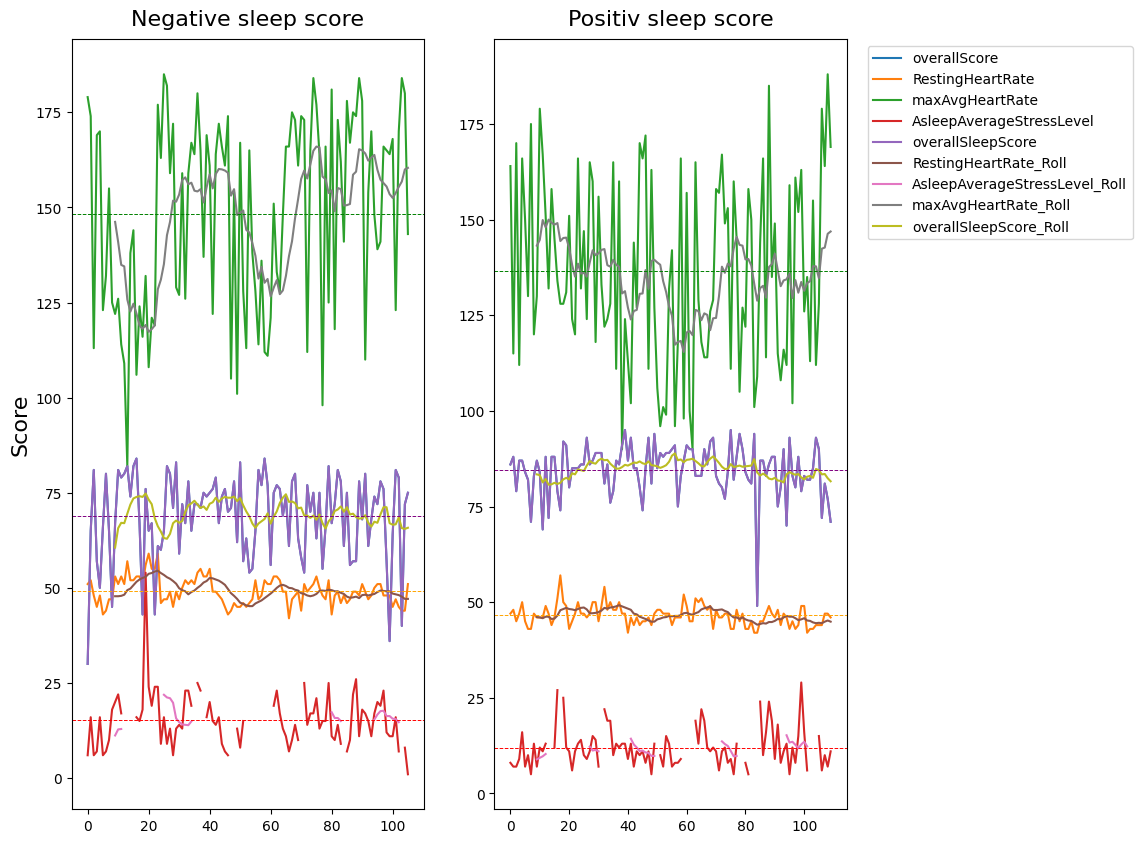

In [22]:
fig, axes = plt.subplots(ncols=2)
df_neg.plot(ax=axes[0], figsize=(10, 10), legend=False)
df_pos.plot(ax=axes[1], figsize=(10, 10), legend=False)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
axes[0].set_ylabel('Score',fontdict={'fontsize':16})
axes[0].set_title('Negative sleep score', pad=10, fontdict={'fontsize':16})
axes[1].set_title('Positiv sleep score', pad=10, fontdict={'fontsize':16})

cols = {'overallScore':'purple', 'RestingHeartRate':'orange', 'maxAvgHeartRate':'green','AsleepAverageStressLevel':'red'}
for col, color in cols.items():
    axes[0].axhline(y=np.nanmean(df_neg[col]), color=color, linestyle='--', linewidth=0.7, label='Avg') # add average line
    axes[1].axhline(y=np.nanmean(df_pos[col]), color=color, linestyle='--', linewidth=0.7, label='Avg') # add average line

* Im Schnitt wird besser geschlafen, wenn die Herzfrequenz am Tag (grün) nicht in die Höhe getrieben wurde, z.B. durch Stress oder Sport
* Bei einem schlechten Sleep Score ist die Ruheherzfrequenz am Tag (orange) tendentiell etwas höher
* Der Stresspegel im Schlaf (rot) ist bei gutem Schlaf niedriger 

### Consider sleepFeedback relate to insight

In [23]:
query = "SELECT overallScore, sleepFeedback, insight FROM sleep_data WHERE insight NOT LIKE 'NONE%';"
df_fb = pd.read_sql(query, connection)
df_fb = df_fb.sort_values('sleepFeedback')

In [24]:
df_fb2 = df_fb[['sleepFeedback', 'insight']].value_counts().reset_index(name='count') # count every existing combination of slepFeedback and insight
df_fb['count'] = df_fb2['count'] * 20 # make the bubbles bigger
df_fb['overallScore'] = df_fb['overallScore'].apply(pd.to_numeric) # change datatype to numeric

Plot scatterplot

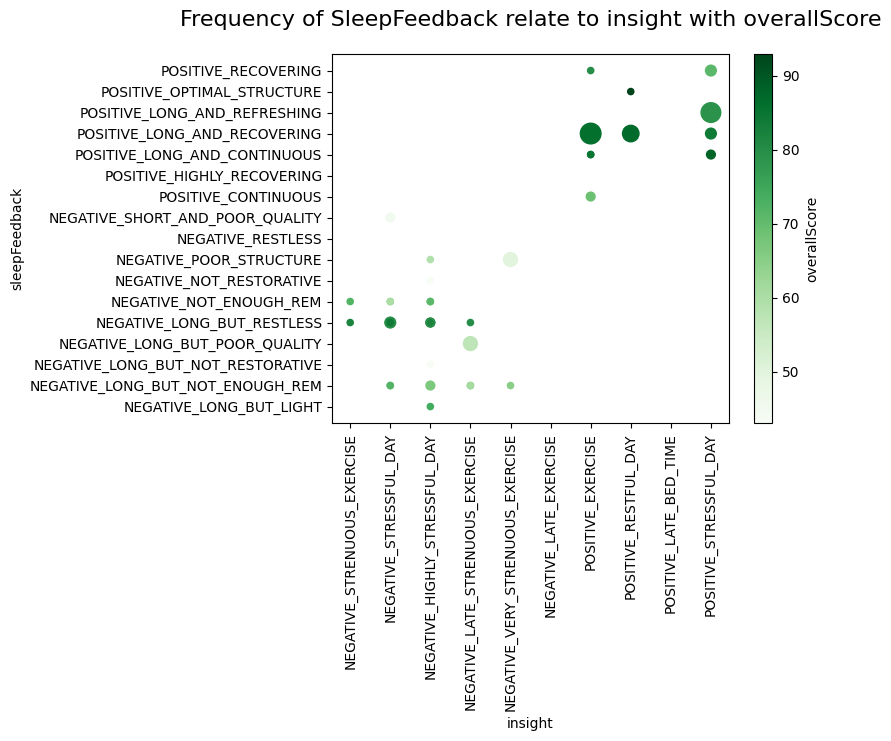

In [31]:
ax1 = df_fb.plot.scatter(x='insight', y='sleepFeedback', c='overallScore', cmap='Greens', s='count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);
ax1.set_title('Frequency of SleepFeedback relate to insight with overallScore', pad=20, fontdict={'fontsize':16});

**Info**: die Größe der Punkte zeigt an, wie häufig diese Kombination von sleepFeedback und insight aufgetreten ist -> je größer, desto häufiger
* Laut dem Diagramm erfährt man den besten Schlaf nach einem "POSITIVE_STRESSFUL_DAY"
* Guter Schlaf ist am häufigsten bei "POSITIVE_LONG_AND_RECOVERING" 
* Es fällt auf, dass der Schlaf nach negativ stressigen Tagen ruhelos mit zu wenig REM-Schlaf ist.
* "NEGATIVE_HIGHLY_STRESSFUL_DAY"s führen am häufigsten zu schlechtem Schlaf